# DAT200 CA3 2023
#### Karin Mollatt
Kaggle username: karinmollatt

---

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Reading data

In [3]:
# loading data
train_df =  pd.read_csv('assets/train.csv', index_col=0)
test_df = pd.read_csv('assets/test.csv', index_col=0)

### Data exploration and visualisation
I visualize the raw data with violin- and scatterplots to inspect for possible outliers or inconsistencies, and to observe if this can have an impact on the model afterwards.

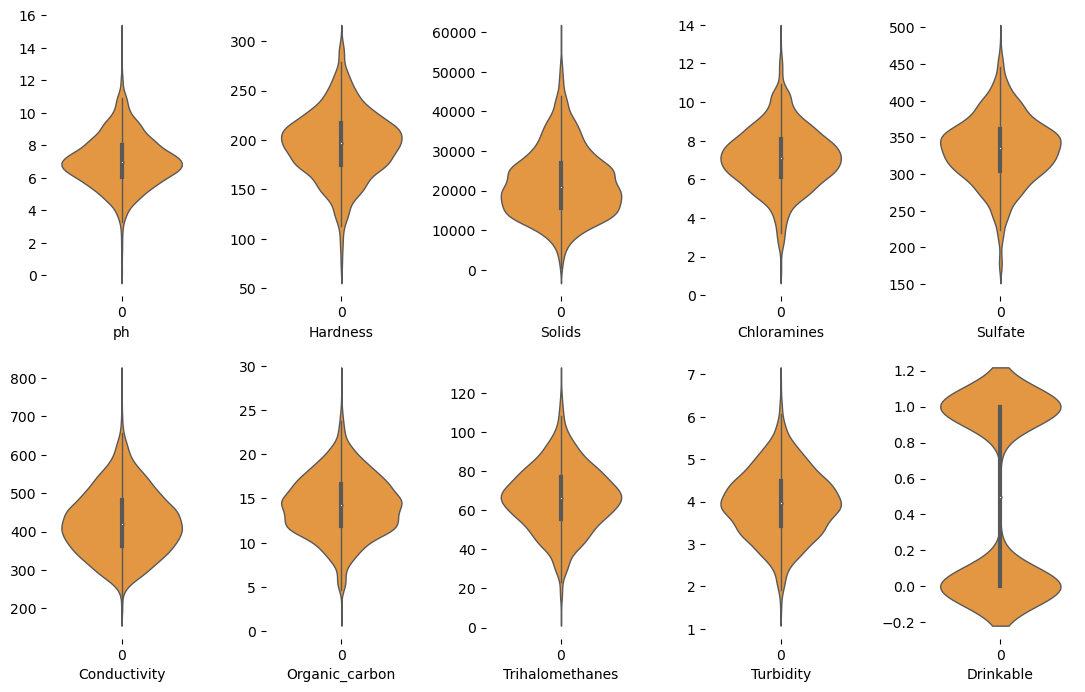

In [4]:
# violinplot of each feature
row_no = 2
col_no = 5
subplot_no = 1

plt.figure(figsize=(11,7))

for col in train_df.columns:
    plt.subplot(row_no, col_no, subplot_no)
    plt.xlabel(col)
    sns.violinplot(data=train_df[col], scale='count', linewidth=1, palette='YlOrBr')
    subplot_no = subplot_no + 1

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [1]:
# pairplot
plt.figure()
sns.pairplot(train_df, hue='Drinkable', palette='YlOrBr')
plt.show()

NameError: name 'plt' is not defined

<Figure size 640x480 with 0 Axes>

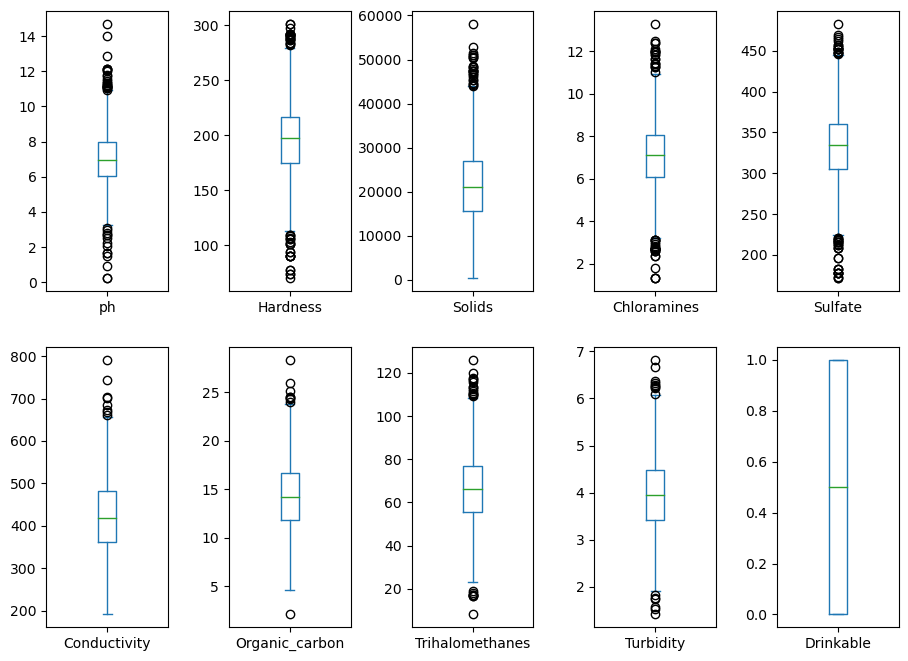

In [5]:
# box plot
plt.figure()
train_df.plot(kind='box', 
              subplots=True, 
              layout=(2, 5),
              figsize=(11,8),
              sharex=False, 
              sharey=False)
plt.subplots_adjust(wspace=0.5) 
plt.show()

From the three visualizations of the raw data, one can observe that almost all the features are approximately normally distributed. The pair plot displays that the to classes are not linearly separable, and one should therefore not use a model that predicts based one a linear function. The boxplot shows some outliers in all features, whereas for some features such as `Solids` and `Conductivity` (and maybe `Organic_carbon`) the distribution is more skewed, and the outliers are gathered in a tail. 

### Data cleaning

#### Interquartile Range
The interquartile range (IQR) contains the center part of your dataset. The range includes the data within the 25% and 75% quartile - in other words the middle 50% of your data. The box in a boxplot represents the interquartile range, whereas connected whiskers include 1.5 length of the box on each side (25%- and 75%-markers.) 

<span style="color:#7F8C8D">Source: [Interquartile range](https://www.statisticshowto.com/probability-and-statistics/interquartile-range/) (Achieved 20.03.23)</span>

In [6]:
# check of outliers from Interquartile Range
iqr_train_df = train_df.copy()

for col in iqr_train_df:
    q75, q25 = np.percentile(iqr_train_df.loc[:,col], [75,25])
    iqr = q75 - q25

    max_val = q75 + (1.5*iqr)
    min_val = q25 - (1.5*iqr)

    iqr_train_df.loc[iqr_train_df[col] < min_val, col] = np.nan
    iqr_train_df.loc[iqr_train_df[col] > max_val, col] = np.nan
    
sum_iqr_outliers = iqr_train_df.isnull().sum()

print(f'Sum of IQR outliers per feature:\n{sum_iqr_outliers}')
print(f'\nSum of all IQR outliers: {sum(sum_iqr_outliers)}')
print(f'Removing these rows will make up {sum(sum_iqr_outliers)/len(iqr_train_df)*100:.2f}% of the dataset.')

iqr_train_df = iqr_train_df.dropna(axis = 0)

Sum of IQR outliers per feature:
ph                 38
Hardness           44
Solids             26
Chloramines        47
Sulfate            48
Conductivity        8
Organic_carbon      9
Trihalomethanes    23
Turbidity          15
Drinkable           0
dtype: int64

Sum of all IQR outliers: 258
Removing these rows will make up 12.65% of the dataset.


One can observe that by using the Interquartile Range to detect outliers, 12.65% percent of the dataset would categorize as outliers. This is a big part of the dataset, and by removing these, one can lose valuable information. To deal with this, one could have calculated the feature mean of the outlier value, or other similar techniques to replace the outlier value. From the output I decide that the outlier part is significant, and that one should try another outlier detecting technique.

#### The Empirical Rule
If one assumes that the data is approximately normally distributed, one can use the empirical rule. The rule states that 68-95-99.7 % of the data lies within 1-2-3 standard deviations (std) from the mean (center of data). Therefore, one can say outliers outside the boundary of 3 std's are extreme, and will bring noise to the rest of your data.

<span style="color:#7F8C8D">Source: [Empirical Rule: Definiton & Formula](https://statisticsbyjim.com/probability/empirical-rule/) (Achieved 20.03.23)</span>

In [7]:
# check of outliers from 3 standard deviations
std_train_df = train_df.copy()

for col in std_train_df:
    col_std = np.std(std_train_df.loc[:,col], axis=0, ddof=1)
    col_mean = np.mean(std_train_df.loc[:,col], axis=0)

    max = col_mean + (3*col_std)
    min = col_mean - (3*col_std)

    std_train_df.loc[std_train_df[col] < min,col] = np.nan
    std_train_df.loc[std_train_df[col] > max,col] = np.nan
    
sum_std_outliers = std_train_df.isnull().sum()

print(f'Sum of standard deviation outliers per feature:\n{sum_std_outliers}')
print(f'\nSum of all std outliers: {sum(sum_std_outliers)}')
print(f'Removing these rows will make up {sum(sum_std_outliers)/len(std_train_df)*100:.2f}% of the dataset.')

std_train_df = std_train_df.dropna(axis = 0)

Sum of standard deviation outliers per feature:
ph                 16
Hardness           12
Solids             11
Chloramines        11
Sulfate            12
Conductivity        5
Organic_carbon      4
Trihalomethanes     9
Turbidity           6
Drinkable           0
dtype: int64

Sum of all std outliers: 86
Removing these rows will make up 4.22% of the dataset.


One can observe that the empirical rule only affects about 4% of the dataset, which I evaluate to be a reasonable amount to remove and proceed without.

### Data exploration after cleaning

After removing the outliers, I plot the exact same visualizations as previously, to observe if the difference is remarkable.

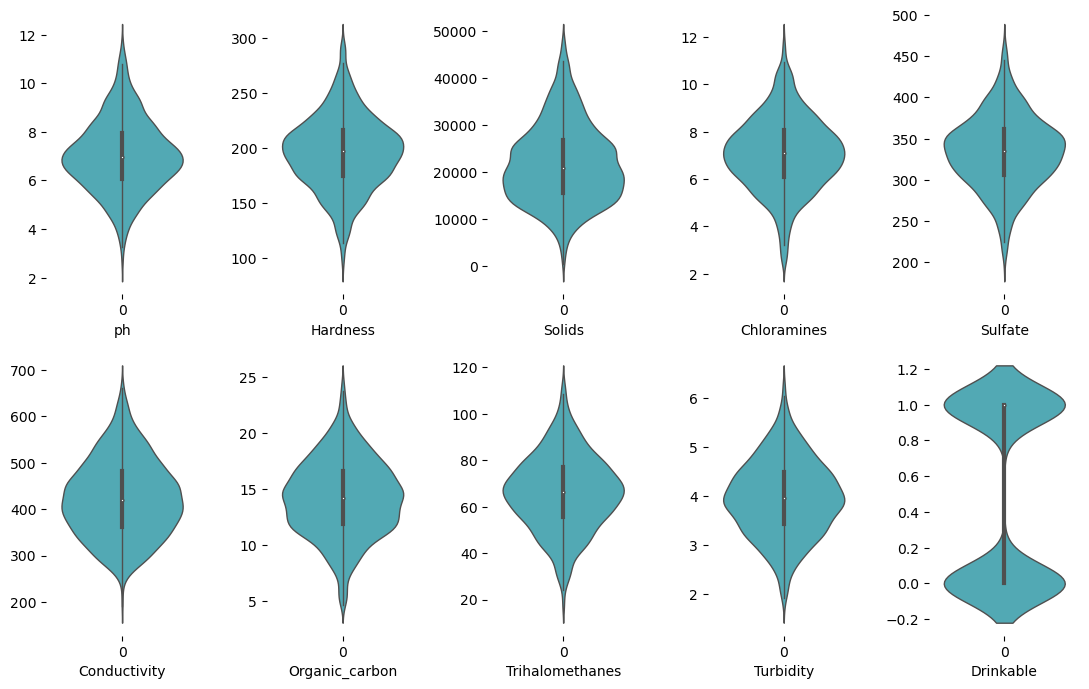

In [8]:
# violinplot of each feature
row_no = 2
col_no = 5
subplot_no = 1

plt.figure(figsize=(11,7))

for col in std_train_df.columns:
    plt.subplot(row_no, col_no, subplot_no)
    plt.xlabel(col)
    sns.violinplot(data=std_train_df[col], scale='count', linewidth=1, palette='YlGnBu_r')
    subplot_no = subplot_no + 1

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

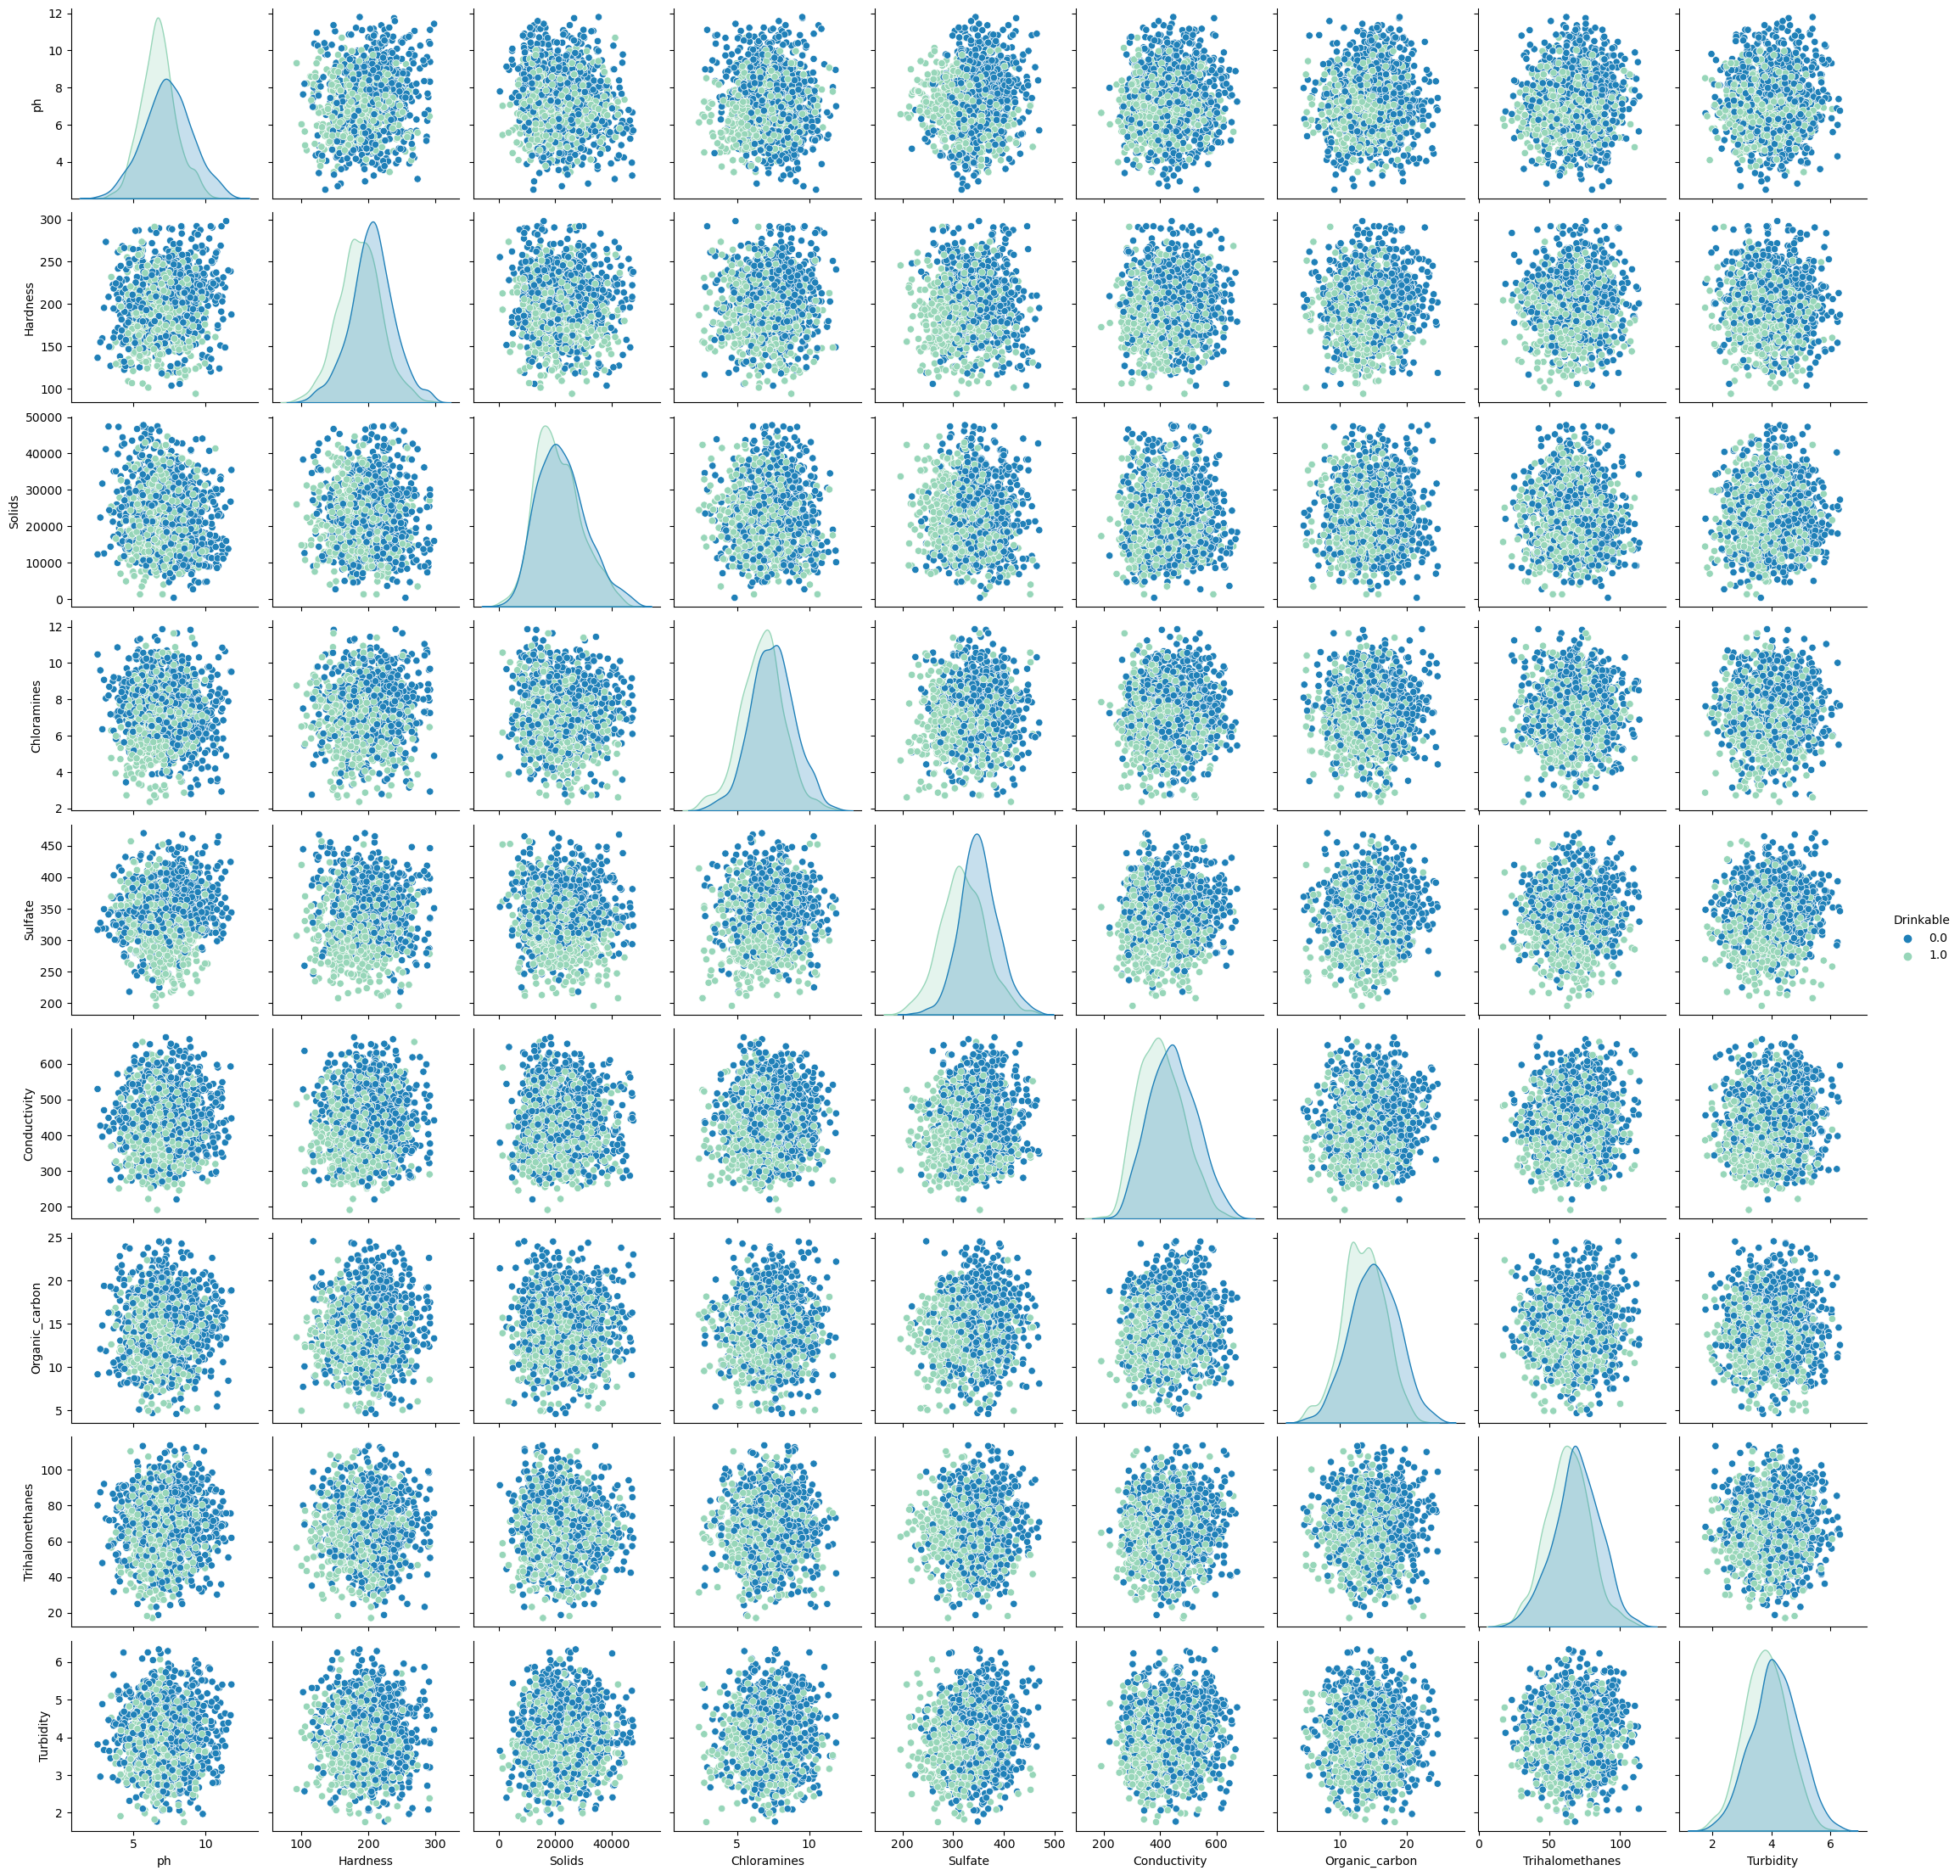

In [9]:
# pairplot
plt.figure()
sns.pairplot(std_train_df, hue='Drinkable', palette='YlGnBu_r')
plt.show()

<Figure size 640x480 with 0 Axes>

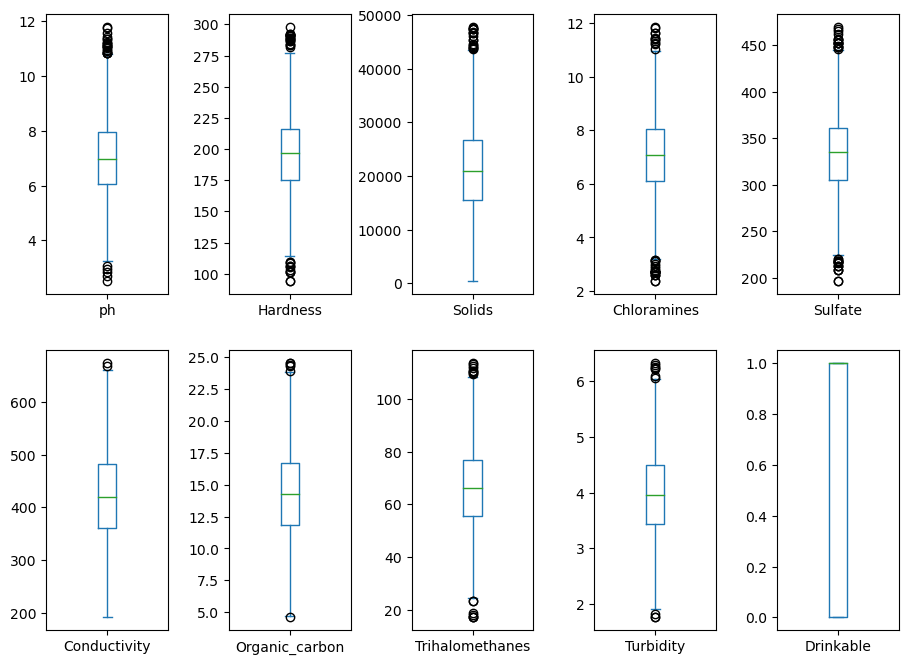

In [10]:
# box plot
plt.figure()
std_train_df.plot(kind='box', 
              subplots=True, 
              layout=(2, 5),
              figsize=(11,8),
              sharex=False, 
              sharey=False)
plt.subplots_adjust(wspace=0.5) 
plt.show()

From the visualizations before and after the data cleaning, one can observe that the distributions in the violin plots now are even closer to a good normal distribution. The boxplot visualizations shows that there still are some outliers in some of the features, but to avoid removing a too large part of the dataset, I continued with this proportion of data.

### Data preprocessing

#### Train test split

In [11]:
# splitting features and target in two dataframes
features_train_df = std_train_df.iloc[:,:-1]
target_train_df = std_train_df.iloc[:,-1]

# splitting these dataframes in train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    features_train_df, target_train_df,
    test_size=0.3, random_state=1, stratify=target_train_df)

### Modelling
To find the optimal amount of trees to use in the model, I have looped through a range and gathered the accuracy results in a list. Then these results were visualized, and the maximum accuracy with index were extracted and proceeded with.

In [12]:
# training model for different no of trees
accTestListForest = [] 

for no_trees in range(200, 1001, 50):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=no_trees, 
                                    random_state=1,
                                    n_jobs=-1)
    forest.fit(X_train, y_train)
    
    accTestListForest.append(forest.score(X_test, y_test))

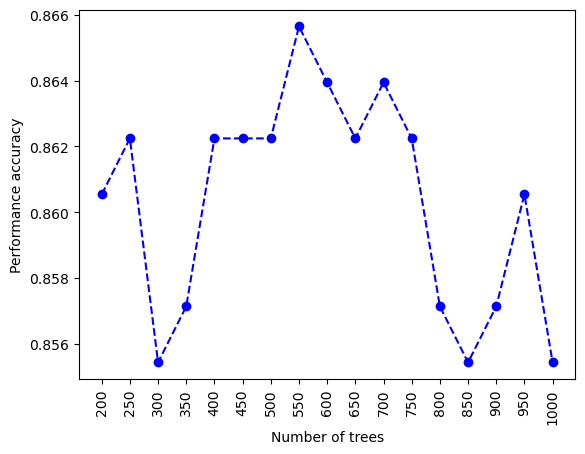

In [13]:
# visualizing accuracies
plt.figure()
plt.plot(accTestListForest,'bo--')
plt.xticks(ticks=[i for i in range(17)],
           labels=[i for i in range(200,1001,50)],
           rotation=90)
plt.xlabel("Number of trees")
plt.ylabel("Performance accuracy")
plt.show()

In [14]:
# extracting largest accuracy with index to proceed with
maxAccForest = np.max(accTestListForest)

for idx, acc in enumerate(accTestListForest):
    if maxAccForest == accTestListForest[idx]:
        tree_number = 50*idx + 200
        print(f'Maximum accuracy of {accTestListForest[idx]:.4f} with {tree_number} trees.')
        break

Maximum accuracy of 0.8656 with 550 trees.


### Final Evaluation

In [15]:
# training model with best parameters
final_forest = RandomForestClassifier(criterion='gini',
                                      n_estimators=tree_number,
                                      random_state=1,
                                      n_jobs=-1)
final_forest.fit(X_train, y_train)

# predicting results
final_pred = final_forest.predict(test_df)

### Kaggle submission

In [16]:
# converting prediction array to dataframe, and writing to csv-file
final_pred = final_forest.predict(test_df)
final_pred_df = pd.DataFrame(final_pred, columns=["Drinkable"]).astype('int')
final_pred_df.to_csv('submission.csv', index=True, index_label="Index", sep=',')